In [1]:
import torch
import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float64)
torch.manual_seed(42);

In [2]:
def olivers_fn(X: torch.Tensor, w: float = 1, gamma: float = 0.01, noise: float = 0):
    y = torch.prod(torch.sin(w * (X + 1)) * (1 - torch.tanh(gamma * ((X + 1) ** 2))), dim=-1, keepdim=True)
    if noise:
        y += torch.normal(0, noise, size=y.shape)
    return y

def det_fn(X: torch.Tensor, Y: torch.Tensor):
    return (2 * torch.exp(-torch.mean(X ** 2 / 3, dim=-1, keepdim=True)) * Y)# + (0.2 * X.mean(dim=-1, keepdim=True))
def constraint_fn(X: torch.Tensor):
    return (X.mean(dim=-1, keepdim=True) - 5.)        

In [3]:
N = 30
NOISE = 0.1
bounds = torch.tensor([[-8.], [8.]])
x = torch.linspace(bounds[0][0], bounds[1][0], 10000).unsqueeze(-1)
x_sample = torch.normal(mean=0, std=5, size=(N, 1))
x_sample = torch.clamp(x_sample, bounds[0].item(), bounds[1].item())

y_true_m = olivers_fn(x, noise=0)
y_true = det_fn(x, y_true_m)
y_sample_m = olivers_fn(x_sample, noise=NOISE)
y_sample = det_fn(x_sample, y_sample_m)

x_sample = x_sample.repeat(1,1)
x = x.repeat(1,1)
bounds = bounds.repeat(1,1)


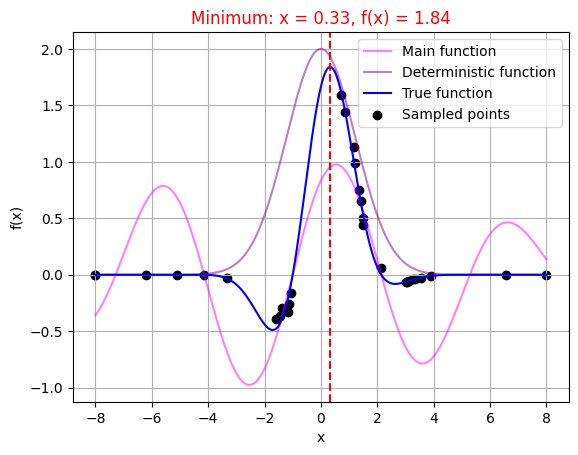

In [4]:
plt.plot(x[:,0],y_true_m, color = 'magenta', label = 'Main function', alpha = 0.5)
plt.plot(x, 2 * torch.exp(-torch.mean(x ** 2 / 3, dim=-1, keepdim=True)), color = 'purple', label = 'Deterministic function', alpha =0.5)
plt.plot(x[:,0],y_true, color = 'blue', label = 'True function')
plt.scatter(x_sample[:,0],y_sample, color = 'black', label = 'Sampled points')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true.max())
plt.axvline(x[:,0][np.argmax(y_true)],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [5]:
class GP_RBF(botorch.models.SingleTaskGP):
    def __init__(self,bounds,device = 'cpu', deterministic_loss = None):
        self.device = device
        self.bounds = bounds.to(device)
        self.mean_y = 0
        self.std_y = 0
    def fit(self,X:torch.tensor,Y:torch.tensor,use_scipy = True,options:dict = None,**kwargs):
        X = X.to(self.device)
        Y = Y.to(self.device)
        X = self.normalization(X, self.bounds)
        super().__init__(X,Y)#,outcome_transform = botorch.models.transforms.Standardize(m=1), **kwargs)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        botorch.fit.fit_gpytorch_mll(mll)
        return self
    @staticmethod
    def normalization(X:torch.tensor, bounds):
        #return X
        return (X - bounds[0,:]) / (bounds[1,:] - bounds[0,:])
    def predict(self,x,return_std = True,apply_det = False,**kwargs):
        #self.eval()
        observed_pred = self.posterior(x,**kwargs)
        y_pred = (-1)*observed_pred.mean.cpu()
        if apply_det: y_pred = det_fn(x.reshape(-1,self.bounds.size(-1)),y_pred.reshape(-1,1)).reshape(y_pred.shape)
        y_pred = y_pred*(-1)
        std_pred = observed_pred.variance.sqrt()
        if apply_det: 
            std_pred = torch.where(constraint_fn(x)>0, std_pred*0.1, std_pred)
        if return_std: return y_pred,std_pred
        else: return y_pred
    def posterior(self, X, **kwargs):
        """
        Override posterior to apply weight loss transformation for scalar outputs
        """
        posterior = super().posterior(self.normalization(X, self.bounds), **kwargs)
        return posterior
    def deterministic_loss(self,X,Y):
        return det_fn(X,Y)
    
class SingleTaskIBNN(GP_RBF):
    def __init__(self, bounds, device = torch.device('cpu'),
                 var_w = None,var_b = None,depth = 3, deterministic_loss = None
                ):
        super().__init__(bounds,device)
        self.model_args = {'var_w':var_w,'var_b':var_b, 'depth':depth}
        self._kernel = None
    def fit(self,X,Y,use_scipy = True,options:dict = None,**kwargs):
        if self._kernel is None: kernel = botorch.models.kernels.InfiniteWidthBNNKernel(depth=self.model_args['depth'])
        else: kernel = self._kernel
        super().fit(X,Y,covar_module=kernel,use_scipy = use_scipy,options= options,**kwargs)
        self._kernel = kernel
        return self

In [ ]:
gpr = GP_RBF(bounds)
gpr.fit(x_sample,(-1)*y_sample)

In [7]:
with torch.no_grad():   
    y_pred, std = gpr.predict(x,return_std = True)
    y_pred *= -1
    std = std.flatten()

In [8]:
std_main = std.clone()

In [ ]:
plt.plot(x[:,0],y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x[:,0],y_pred.detach().cpu().numpy(), color = 'blue', label = 'Predicted function')
plt.fill_between(x[:,0].flatten(),y_pred.flatten()-std,y_pred.flatten()+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample[:,0],y_sample, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [10]:
class Custom_LogEI(botorch.acquisition.LogExpectedImprovement):
    def __init__(self, model, best_f, deterministic_fn = None, constraint_fn = None):
        self.deterministic_fn = deterministic_fn
        self.constraint_fn = constraint_fn
        self._size_x = model.bounds.shape[-1]
        super().__init__(model = model, best_f = best_f)
    def _mean_and_sigma(self, X, compute_sigma = True, min_var = 1e-12):
        mean, sigma = super()._mean_and_sigma(X, compute_sigma, min_var)
        mean *= -1
        mean = self.deterministic_fn(X.reshape(-1,bounds.size(-1)),mean.reshape(-1,1)).reshape(mean.shape)
        mean *= -1
        sigma = torch.where(self.constraint_fn(X).view(sigma.shape)>0, sigma*0.1, sigma)
        return mean, sigma

In [ ]:
acquisition = botorch.acquisition.LogExpectedImprovement(gpr, (-1)*y_sample.min())#Custom_LogEI(gpr, (-1)*y_sample.min(), deterministic_fn=det_fn, constraint_fn=constraint_fn) 
acq_values = acquisition(x.unsqueeze(1)).detach().cpu().numpy()
new_x, ac_opt = botorch.optim.optimize.optimize_acqf(acquisition, bounds, **{'q':1,'num_restarts': 30, 'raw_samples':5000})

fig, ax1 = plt.subplots()

ax1.plot(x[:,0], y_true, color='purple', label='True function', linewidth=6, alpha=0.5)
ax1.plot(x[:,0], y_true_m, color='green', label='Main function', linewidth=3)
ax1.plot(x[:,0], y_pred.detach().cpu().numpy(), color='blue', label='Predicted function')
ax1.fill_between(x[:,0].flatten(), y_pred.flatten()-std, y_pred.flatten()+std, alpha=0.25, color='blue')
ax1.scatter(x_sample[:,0], y_sample, color='black', label='Sampled points', marker='x')
ax1.set_xlabel('x')
ax1.set_ylabel('Function Value')
(-1)*y_sample.min()
ax1.scatter(x_sample[y_sample.argmin()], y_sample.min(), color='blue', label='Current Best', s=100, marker='o')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x[:,0], -np.log10(-acq_values), color='orange', label='Acquisition Function')
ax2.set_ylabel('Acquisition Value')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.scatter(new_x.detach().mean(), -np.log10(-ac_opt.detach()), color='red', label='Next Best Point', s=100, marker='x')
plt.title('Acquisition Function')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('Acquisition Value')
plt.show()

In [18]:
gpr_2 = GP_RBF(bounds)
gpr_2.fit(x_sample,(-1)*y_sample_m)
gpr_2.covar_module = gpr.covar_module
gpr_2.likelihood = gpr.likelihood

In [19]:
with torch.no_grad():   
    y_pred, std = gpr_2.predict(x,return_std = True)
    y_pred *= -1
    std = std.flatten()
    y_pred_det, std_det = gpr_2.predict(x,return_std = True,apply_det = True)
    y_pred_det *= -1
    std_det = std_det.flatten()

In [ ]:
plt.plot(x[:,0],y_true, color = 'purple', label = 'True function',linewidth = 6, alpha = 0.5)
plt.plot(x[:,0],y_true_m, color = 'green', label = 'Main function',linewidth = 3)
plt.plot(x[:,0],y_pred.detach().cpu().numpy(), color = 'blue', label = 'Predicted function')
plt.fill_between(x[:,0].flatten(),y_pred.flatten()-std,y_pred.flatten()+std, alpha = 0.25, color = 'blue')

plt.plot(x[:,0],y_pred_det.detach().cpu().numpy(), color = 'red', label = 'Predicted function + det')
plt.fill_between(x[:,0].flatten(),y_pred_det.flatten()-std_det,y_pred_det.flatten()+std_det, alpha = 0.25, color = 'red')

plt.scatter(x_sample[:,0],y_sample_m, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true_m.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [ ]:
ac_opt

In [ ]:
acquisition = Custom_LogEI(gpr_2, (-1)*y_sample.min(), deterministic_fn=det_fn, constraint_fn=constraint_fn) 
acq_values = acquisition(x.unsqueeze(1)).detach().cpu().numpy()
new_x, ac_opt = botorch.optim.optimize.optimize_acqf(acquisition, bounds, **{'q':1,'num_restarts': 30, 'raw_samples':5000})
with torch.no_grad():
    y_pred_ac,std_ac = acquisition._mean_and_sigma(x.unsqueeze(1),compute_sigma = True)
    y_pred_ac = -y_pred_ac.flatten()
    std_ac = std_ac.flatten() 

fig, ax1 = plt.subplots()
fig.tight_layout()

ax1.plot(x[:,0], y_true, color='purple', label='True function', linewidth=6, alpha=0.5)
ax1.plot(x[:,0], y_true_m, color='green', label='Main function', linewidth=3)
ax1.plot(x[:,0],y_pred_ac, color = 'blue', label = 'Predicted function')
ax1.fill_between(x[:,0].flatten(),y_pred_ac-std_ac,y_pred_ac+std_ac, alpha = 0.25, color = 'blue')
ax1.scatter(x_sample[:,0], y_sample, color='black', label='Sampled points', marker='x')
true_minimal = (x[:,0][np.argmax(y_true)].item(),y_true_m.max())
ax1.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
ax1.scatter(new_x.detach().mean(), -np.log10(-ac_opt.detach()), color='red', label='Next Best Point', s=100, marker='x')

ax1.set_xlabel('x')
ax1.set_ylabel('Function Value')
ax1.scatter(x_sample[y_sample.argmin()], y_sample.min(), color='blue', label='Current Best', s=100, marker='o')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x[:,0], -np.log10(-acq_values), color='orange', label='Acquisition Function')
ax2.set_ylabel('Acquisition Value')
ax2.legend(loc='upper right')


plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('Acquisition Value')

plt.show()





In [ ]:
plt.plot(x[:,0], std, label = 'Reduced GP', linewidth = 3)
plt.plot(x[:,0], std_main,'-.',  label = 'Standard GP')
plt.plot(x[:,0], std_ac,'-.', label = 'Reduced GP + Det')
plt.grid()
plt.legend()
plt.show()